Projet Clustering
SEARLE Oliver B11

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

J'ai choisi d'importer les stats des Jouers

In [9]:
home_data = pd.read_csv('X_Train_Data/train_home_player_statistics_df.csv')
away_data = pd.read_csv('X_Train_Data/train_away_player_statistics_df.csv')

all_data = pd.concat([home_data, away_data], axis=0, ignore_index=True)
player_stats = all_data.groupby("PLAYER_NAME").mean(numeric_only=True)

In [10]:
print(all_data.describe())

                  ID  PLAYER_ACCURATE_CROSSES_season_sum  \
count  473211.000000                       416452.000000   
mean     6151.401060                            7.931181   
std      3551.942239                           15.122378   
min         0.000000                            0.000000   
25%      3079.000000                            0.000000   
50%      6151.000000                            1.000000   
75%      9227.000000                            9.000000   
max     12302.000000                          100.000000   

       PLAYER_ACCURATE_PASSES_season_sum  PLAYER_AERIALS_WON_season_sum  \
count                      416452.000000                  416452.000000   
mean                           22.724194                      12.708262   
std                            20.871685                      16.183625   
min                             0.000000                       0.000000   
25%                             6.000000                       1.000000   
50%      

In [ ]:

# Étape 1 : Sélection de features améliorées
features = [
    'PLAYER_MINUTES_PLAYED_season_sum',
    'PLAYER_RATING_season_average', 'PLAYER_RATING_5_last_match_average',
    'PLAYER_GOALS_season_sum', 'PLAYER_ASSISTS_season_sum',
    'PLAYER_KEY_PASSES_season_sum', 'PLAYER_PASSES_season_sum',
    'PLAYER_BIG_CHANCES_CREATED_season_sum', 'PLAYER_SHOTS_ON_TARGET_season_sum',
    'PLAYER_SHOTS_TOTAL_season_sum',
    'PLAYER_TACKLES_season_sum', 'PLAYER_INTERCEPTIONS_season_sum',
    'PLAYER_CLEARANCES_season_sum',
    'PLAYER_SUCCESSFUL_DRIBBLES_season_sum', 'PLAYER_DRIBBLED_ATTEMPTS_season_sum',
    'PLAYER_DUELS_WON_season_sum', 'PLAYER_DUELS_LOST_season_sum',
    'PLAYER_GOALS_5_last_match_sum', 'PLAYER_ASSISTS_5_last_match_sum',
    'PLAYER_KEY_PASSES_5_last_match_sum'
]

# Nettoyage
numeric_data = player_stats[features].copy()
numeric_data = numeric_data.replace([np.inf, -np.inf], np.nan)
numeric_data = numeric_data.dropna(axis=1, thresh=int(0.5 * len(numeric_data)))
numeric_data = numeric_data.dropna(axis=0, thresh=int(0.5 * numeric_data.shape[1]))
numeric_data = numeric_data.fillna(numeric_data.mean(numeric_only=True))

In [ ]:
# Création de features dérivées intelligentes

# Ratio duels gagnés
numeric_data['PLAYER_DUELS_TOTAL'] = numeric_data['PLAYER_DUELS_WON_season_sum'] + numeric_data['PLAYER_DUELS_LOST_season_sum']
numeric_data['PLAYER_DUELS_WIN_RATIO'] = numeric_data['PLAYER_DUELS_WON_season_sum'] / numeric_data['PLAYER_DUELS_TOTAL'].replace(0, np.nan)

# Efficacité offensive
numeric_data['SHOTS_ACCURACY'] = numeric_data['PLAYER_SHOTS_ON_TARGET_season_sum'] / numeric_data['PLAYER_SHOTS_TOTAL_season_sum'].replace(0, np.nan)
numeric_data['GOALS_PER_SHOT'] = numeric_data['PLAYER_GOALS_season_sum'] / numeric_data['PLAYER_SHOTS_TOTAL_season_sum'].replace(0, np.nan)

# Création vs passes
numeric_data['KEY_PASSES_RATIO'] = numeric_data['PLAYER_KEY_PASSES_season_sum'] / numeric_data['PLAYER_PASSES_season_sum'].replace(0, np.nan)
numeric_data['ASSISTS_PER_PASS'] = numeric_data['PLAYER_ASSISTS_season_sum'] / numeric_data['PLAYER_PASSES_season_sum'].replace(0, np.nan)

# Forme récente
numeric_data['GOAL_FORM_RATIO'] = numeric_data['PLAYER_GOALS_5_last_match_sum'] / numeric_data['PLAYER_GOALS_season_sum'].replace(0, np.nan)
numeric_data['RATING_IMPROVEMENT'] = numeric_data['PLAYER_RATING_5_last_match_average'] - numeric_data['PLAYER_RATING_season_average']

# Dribbles
numeric_data['DRIBBLE_EFFICIENCY'] = numeric_data['PLAYER_SUCCESSFUL_DRIBBLES_season_sum'] / numeric_data['PLAYER_DRIBBLED_ATTEMPTS_season_sum'].replace(0, np.nan)

# Ratios par 90 minutes
per_90 = numeric_data['PLAYER_MINUTES_PLAYED_season_sum'] / 90
numeric_data['GOALS_PER_90'] = numeric_data['PLAYER_GOALS_season_sum'] / per_90.replace(0, np.nan)
numeric_data['ASSISTS_PER_90'] = numeric_data['PLAYER_ASSISTS_season_sum'] / per_90.replace(0, np.nan)
numeric_data['KEY_PASSES_PER_90'] = numeric_data['PLAYER_KEY_PASSES_season_sum'] / per_90.replace(0, np.nan)

# Nettoyage des NaN générés par les ratios
numeric_data = numeric_data.fillna(0)

# Suppression des colonnes intermédiaires inutiles
numeric_data.drop(columns=[
    'PLAYER_DUELS_WON_season_sum', 'PLAYER_DUELS_LOST_season_sum',
    'PLAYER_DUELS_TOTAL', 'PLAYER_DRIBBLED_ATTEMPTS_season_sum',
    'PLAYER_SHOTS_TOTAL_season_sum', 'PLAYER_PASSES_season_sum'
], inplace=True, errors='ignore')

# Mise à jour de la liste des features finales
features = numeric_data.columns.tolist()


In [ ]:
# Normalisation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

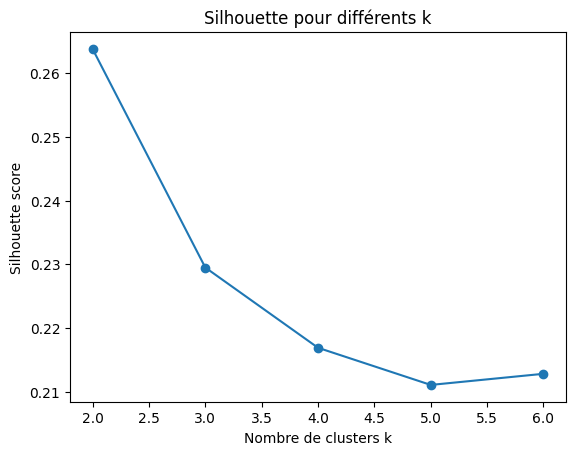

In [27]:
# Choix de K
sil_scores = []
ks = range(2, 7)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(scaled_data)
    sil_scores.append(silhouette_score(scaled_data, km.labels_))

plt.plot(ks, sil_scores, marker='o')
plt.xlabel("Nombre de clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette pour différents k")
plt.show()

In [ ]:
# Clustering KMeans avec k choisi
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Aligner les indices pour éviter les erreurs
player_data_cleaned = player_stats.loc[numeric_data.index].copy()
player_data_cleaned['Cluster'] = clusters

# Ajouter les colonnes dérivées au DataFrame nettoyé
for col in numeric_data.columns:
    player_data_cleaned[col] = numeric_data[col].values


In [ ]:
# Réduction de dimension pour visualisation
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Afficher les composantes
loadings = pd.DataFrame(pca.components_, columns=numeric_data.columns, index=['PC1', 'PC2'])
print(loadings.T)

                                            PC1       PC2
PLAYER_MINUTES_PLAYED_season_sum       0.247678  0.272175
PLAYER_RATING_season_average           0.268893  0.197354
PLAYER_RATING_5_last_match_average     0.269191  0.195499
PLAYER_GOALS_season_sum                0.226343 -0.203825
PLAYER_ASSISTS_season_sum              0.260923 -0.139800
PLAYER_KEY_PASSES_season_sum           0.291510 -0.073934
PLAYER_BIG_CHANCES_CREATED_season_sum  0.258521 -0.119283
PLAYER_SHOTS_ON_TARGET_season_sum      0.255505 -0.173568
PLAYER_TACKLES_season_sum              0.210524  0.296187
PLAYER_INTERCEPTIONS_season_sum        0.159108  0.395581
PLAYER_CLEARANCES_season_sum           0.091260  0.414418
PLAYER_SUCCESSFUL_DRIBBLES_season_sum  0.227752 -0.023264
PLAYER_GOALS_5_last_match_sum          0.225120 -0.213419
PLAYER_ASSISTS_5_last_match_sum        0.260116 -0.151191
PLAYER_KEY_PASSES_5_last_match_sum     0.292244 -0.086632
PLAYER_DUELS_WIN_RATIO                 0.120963  0.265343
SHOTS_ACCURACY

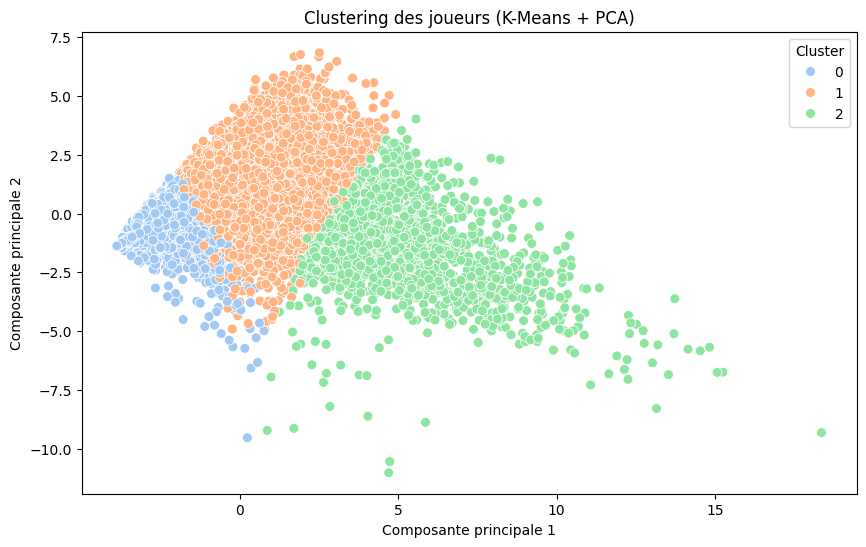

In [ ]:
# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette='pastel', s=50)
plt.title('Clustering des joueurs (K-Means + PCA)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
# Analyse des clusters
features = numeric_data.columns.tolist()
cluster_summary = player_data_cleaned.groupby('Cluster')[features].mean()
print(cluster_summary)

         PLAYER_MINUTES_PLAYED_season_sum  PLAYER_RATING_season_average  \
Cluster                                                                   
0                                7.235371                     19.268963   
1                               45.900429                     66.118065   
2                               58.653653                     78.520949   

         PLAYER_RATING_5_last_match_average  PLAYER_GOALS_season_sum  \
Cluster                                                                
0                                 19.411848                 0.398581   
1                                 64.694145                 3.977875   
2                                 76.923436                20.158765   

         PLAYER_ASSISTS_season_sum  PLAYER_KEY_PASSES_season_sum  \
Cluster                                                            
0                         0.527034                      0.810659   
1                         5.099004                      9.2